# Wolverine Mass Balance - Index Method

### Import necessary modules

In [1]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats
import rasterio
from rasterio.warp import Resampling


In [2]:
# These are functions that I started working on in 12-780
# The include functions for basic raster file processing, glacier-specific calculations, and plotting
from raster_basics.RasterBasics import show_fig, rasterLike
from raster_basics.RasterBasics import shpReprojection, shpClip, tifReprojectionResample, fillHole
from raster_basics.BaseFunctions import altitudeAggregation, glacierOutline
from raster_basics.GlacierFunctions import totalMassBalance, totalMassBalanceValue
from raster_basics.DataPlots import plotMany, plotData


### Identify data files and prep files

In [3]:
crs = 'EPSG:32606'  # UTM zone 6N
res = 20 # output pixel resolution (m)
rho = 850 # our density assumption

In [4]:
rgi_glaciers = '/Users/albinwells/Desktop/GlacierMB/Other/01_rgi60_Alaska-2.shp'
dem_file = '/Users/albinwells/Desktop/GlacierMB/Other/RGI1_DEM/RGI60-01.09162_dem.tif'
dhdt_file = '/Users/albinwells/Desktop/GlacierMB/Other/RGI1 Elevation Change 2015-2020/N60W149_2015-01-01_2020-01-01_dhdt.tif'


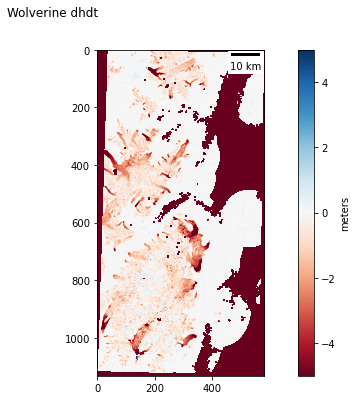

In [5]:
# let's look at initial data files
show_fig(rasterio.open(dhdt_file).read(1), 'Wolverine dhdt', 'RdBu', 'meters', res=rasterio.open(dhdt_file).res[0], 
         vmin=-5, vcenter=0, vmax=5)


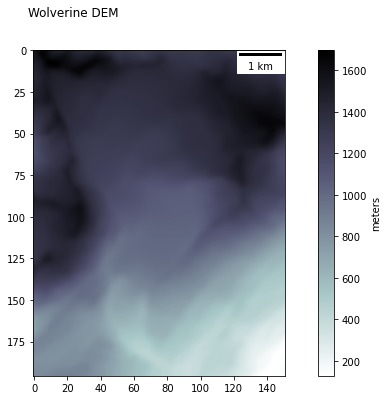

In [6]:
show_fig(rasterio.open(dem_file).read(1), 'Wolverine DEM', 'bone_r', 'meters', res=rasterio.open(dem_file).res[0])


We can see Wolverine in the DEM, but right now, our dhdt file is pretty zoomed out! See the scale difference. We'll use our glacier outline to clip these to Wolverine

### Extract our glacier outline

In [7]:
glaciers = gpd.read_file(rgi_glaciers)
wolverine = glaciers[glaciers['Name']=='Wolverine Glacier']

wolverine_file = 'wolverine.shp'
wolverine.to_file(wolverine_file)


<AxesSubplot:>

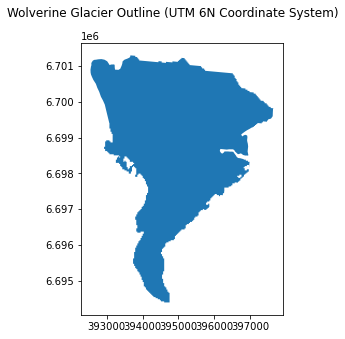

In [8]:
reprojected_shp = 'wolverine_utm.shp'
shpReprojection(wolverine_file, crs, reprojected_shp)
wolverine_utm = gpd.read_file(reprojected_shp)

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Wolverine Glacier Outline (UTM 6N Coordinate System)')
wolverine_utm.plot(ax=ax)

### Clip glacier 

In [9]:
with rasterio.open(dem_file, 'r+') as src:
    src.nodata = np.nan

In [10]:
# clipping geotiff to the extent of the shapefile glacier outline
dem_clip = 'wolverine.tif' # output filename
shpClip(dem_file, reprojected_shp, dem_clip, pad_size=1)
print('Initial coordinate system:', rasterio.open(dem_clip).crs)


Initial coordinate system: PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-148.908],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Initial Resolution: (39.0, 39.0)


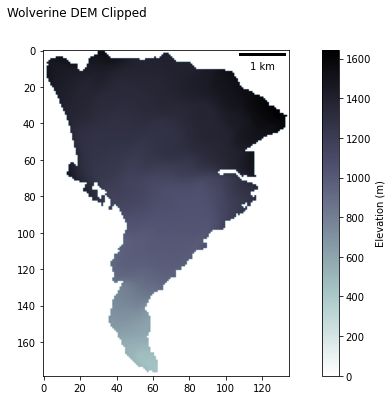

In [11]:
# plot result
im = rasterio.open(dem_clip)
print('Initial Resolution:', im.res)
title = 'Wolverine DEM Clipped'
color = 'bone_r'
ctitle = 'Elevation (m)'
show_fig(im.read(1), title, color, ctitle, res=im.res[0])

### Then, let's reproject the geotiff raster file

In [12]:
dem_reproj = 'wolverine_dem_reprojected.tif' # output filename
tifReprojectionResample(dem_clip, dem_reproj, crs, res, Resampling.cubic_spline)#, extent_file=extent)
print('Reprojected coordinate system and resolution:', rasterio.open(dem_reproj).crs, rasterio.open(dem_reproj).res)


Reprojected coordinate system and resolution: EPSG:32606 (20.0, 20.0)


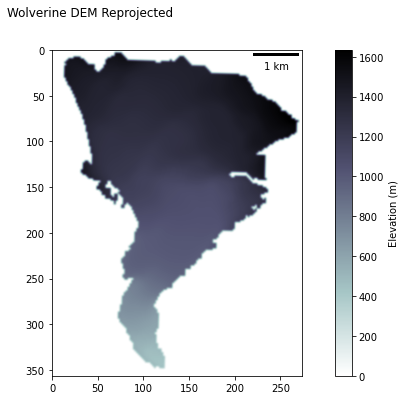

In [13]:
im = rasterio.open(dem_reproj)
show_fig(im.read(1), 'Wolverine DEM Reprojected', color='bone_r', ctitle='Elevation (m)', res=im.res[0], vmin=0)

EPSG:32606 (20.0, 20.0)


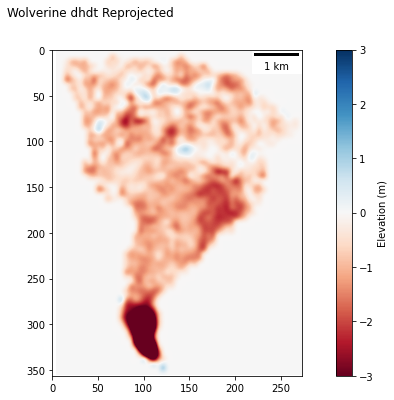

In [14]:
# repeat for the dhdt file
with rasterio.open(dhdt_file, 'r+') as src:
    src.nodata = np.nan

dhdt_clip = 'wolverine_dhdt.tif' # output filename
shpClip(dhdt_file, reprojected_shp, dhdt_clip, pad_size=1)

dhdt_reproj = 'wolverine_dhdt_reprojected.tif' # output filename
tifReprojectionResample(dhdt_clip, dhdt_reproj, crs, res, Resampling.cubic_spline, extent_file=dem_reproj)
print(rasterio.open(dhdt_reproj).crs, rasterio.open(dhdt_reproj).res)

im = rasterio.open(dhdt_reproj)
show_fig(im.read(1), 'Wolverine dhdt Reprojected', color='RdBu', ctitle='Elevation (m)', res=im.res[0], 
         vmin=-3, vcenter=0, vmax=3)

Now, we've clipped and reprojected both files to the same extent around Wolverine.

## Index Site Method

### First, sort through WGMS stake measurements
There are 7 stakes with annual data from 2015-2020. Below, are the names, elevations, and average
annual mass balance values for the 7 stakes from 2015-2020.

In [15]:
stake_names = ['AU', 'N', 'B', 'C', 'S', 'TU-Y', 'Y']
stake_z = [624, 1004, 1067, 1298, 1235, 1370, 1371]
stake_b = [-6797, -2462, -1797, 542, -452, 758, 1285]

The index site method involves dividing the glacier into a few elevation bins (historically it’s been
3 due to the number of stakes). Elevation boundaries are defined as the midpoints between stake elevations. Elevation bin sizes are divided by total glacier area, multiplied by stake mass balance,
and all values are subsequently summer together for glacier-wide mass balance. See [Van Beusekom
et al 2010](https://pubs.usgs.gov/sir/2010/5247/pdf/sir20105247.pdf) and [Cox and March 2004](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/D71F77404501AFCCCE345F399FE23D90/S0022143000214664a.pdf/comparison-of-geodetic-and-glaciological-mass-balance-techniques-gulkana-glacier-alaska-usa.pdf).

Note that this method assumes constant glacier area over the time period (this is a safe assumption
for annual MB but good to note since our data spans 5 years in this analysis – we could alternatively
find glacier-wide MB first and then average the values from 2015-2020 if we wanted instead).

Note this also relies on reliable glacier area outlines.

I will average and combine sites TU and Y since they are at virtually the same elevation. I will
keep the rest of the stake points for now.

In [16]:
stake_names = ['AU', 'N', 'B', 'C', 'S', 'TU-Y']
stake_z = [624, 1004, 1067, 1298, 1235, 1371]
stake_b = [-6797, -2462, -1797, 542, -452, 1022]
# get the elevations between each point
stake_z_midpoints = [(stake_z[i]+z1)/2 for i, z1 in enumerate(stake_z[1:])]
print(stake_z_midpoints)

[814.0, 1035.5, 1182.5, 1266.5, 1303.0]


### Now, compute the glacier-wide value

In [17]:
dem_array = rasterio.open(dem_reproj).read(1) # dem (array-like)
resolution = rasterio.open(dem_reproj).res[0] # pixel resolution

rasterLike(np.ones_like(dem_array), 'raster_ones.tif', dem_reproj)
outline_array = glacierOutline(ones_raster='raster_ones.tif', shape='wolverine_utm.shp', dest='ones_outline.tif')


In [18]:
demGlacier = dem_array*outline_array
dem_array = np.nan_to_num(dem_array)
demGlacier_findMin = demGlacier[demGlacier != 0]

# add min and max to bin midpoints
stake_z_midpoints.insert(0, int(np.nanmin(demGlacier_findMin)))
stake_z_midpoints.append(int(np.nanmax(demGlacier_findMin)+1))
print(stake_z_midpoints)


[67, 814.0, 1035.5, 1182.5, 1266.5, 1303.0, 1637]


In [19]:
outputs = altitudeAggregation(dem_array, dem_array, outline_array, stat='mean', bin_z=stake_z_midpoints)

binMean = outputs[0]
binElevations = outputs[1]
binCounts = outputs[2] # this is what we're after right now
binNumber = outputs[3]

totalArea = np.sum(outline_array) * resolution * resolution
binArea = (binCounts * resolution * resolution).tolist()
print('Total Area (sq.km):', totalArea/1000000)

Total Area (sq.km): 16.7348


In [20]:
weighted_area = binArea/totalArea
assert np.sum(weighted_area) == 1, 'Bin areas do not sum to one. Check that elevation bins span entire glacier'

In [21]:
print('Stake MB (mm w.e.):', stake_b)
print('Stake weight (area fraction):', weighted_area)

Stake MB (mm w.e.): [-6797, -2462, -1797, 542, -452, 1022]
Stake weight (area fraction): [0.08129168 0.13593231 0.16669455 0.1086837  0.08528336 0.4221144 ]


In [22]:
weighted_b = stake_b * weighted_area
wolverine_b = sum(weighted_b)
print('Wolverine glacier-wide mass balance 2015-2020 via index method (mm w.e.):', np.round(wolverine_b, 3))

Wolverine glacier-wide mass balance 2015-2020 via index method (mm w.e.): -734.996


In [23]:
print('Total Mass Loss (kg/yr):', np.round(totalArea*wolverine_b, 0))

Total Mass Loss (kg/yr): -12300004400.0


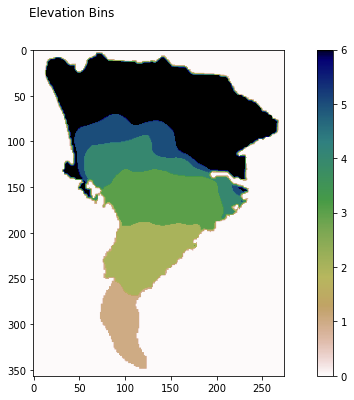

In [24]:
binNumberArray = np.reshape(binNumber, dem_array.shape)
show_fig(binNumberArray, title='Elevation Bins', color='gist_earth_r')


## Geodetic mass balance

In [25]:
# read geotiffs as arrays
dem_array = rasterio.open(dem_reproj).read(1) # dem (array-like)
dhdt_array = rasterio.open(dhdt_reproj).read(1) # dhdt (array-like)
dhdt_array[np.isnan(dhdt_array)] = 0 # filter out nan values

rasterLike(np.ones_like(dem_array), 'raster_ones.tif', dem_reproj)
outline_array = glacierOutline(ones_raster='raster_ones.tif', shape='wolverine_utm.shp', dest='ones_outline.tif')

In [26]:
# obtain the total area and mass balance
totalArea = np.sum(outline_array) * res * res
geodetic_mb = totalMassBalance(dhdt_array, outline_array, density=rho)
geodetic_mb_val = totalMassBalanceValue(geodetic_mb, area=totalArea, res=res)
print('Wolverine mass balance 2015-2020 via geodetic method (mm w.e.):', np.round(geodetic_mb_val,3))


Wolverine mass balance 2015-2020 via geodetic method (mm w.e.): -869.895


## Now, let's find the uncertainty resulting from the geodetic mass balance

### Following a Monte Carlo approach

We prescribe a normally-distributed error of 60 kg/m3 for density, and 1m systematic error for the dhdt, also normally-distributed. Note that 1m of error for dhdt is 0.2m per year, since we are using the 5-year average product. This uncertainty calculation follows [Miles et al 2021](https://www.nature.com/articles/s41467-021-23073-4)

In [27]:
dhdt_array # dhdt array
dhdt_sd = 0.2 # dhdt standard deviation
rho # density value (850)
rho_sd = 60 # density standard deviation

In [28]:
samples = 1000 # number of samples to draw for our Monte Carlo simulation

# initialize arrays to store Monte Carlo simulation pixel mass balance and glacier-wide mass balance
mc_pixel_mb_sys = np.empty((samples, dhdt_array.shape[0], dhdt_array.shape[1]))
mc_mb_sys = np.empty(samples)

In [29]:
# obtain 1000 samples for each parameter
rho_sample = np.random.normal(loc=850, scale=rho_sd, size=samples)
dhdt_sd_sample_sys = np.random.normal(loc=0, scale=dhdt_sd, size=samples)
dhdt_sample_sys = np.empty((samples, dhdt_array.shape[0], dhdt_array.shape[1]))
for i in range(samples):
    dhdt_sample_sys[i] = (dhdt_array + dhdt_sd_sample_sys[i]) * outline_array
    

In [30]:
# MB = dhdt * rho (1000 MB for each pixel)
for row in range(len(dhdt_array)):
    for col in range(len(dhdt_array[0])):
        mc_pixel_mb_sys[:,row,col] = dhdt_sample_sys[:,row,col]*rho_sample
        

In [31]:
# obtain glacier-wide mass balance for each sample (1000 glacier-wide MB estimates)
for i in range(samples):
    mc_mb_sys[i] = totalMassBalanceValue(mc_pixel_mb_sys[i]*outline_array, area=totalArea, res=res)
    

In [32]:
print('Monte Carlo mass balance (mm w.e):', np.round(np.mean(mc_mb_sys), 3))
print('Monte Carlo mass balance uncertainty (mm w.e):', np.round(np.std(mc_mb_sys), 3))
print('\nMB 95% confidence interval (mm w.e): [', np.round(np.mean(mc_mb_sys), 0) - np.round(2*np.std(mc_mb_sys), 0), 
      ',', np.round(np.mean(mc_mb_sys), 0) + np.round(2*np.std(mc_mb_sys), 0), ']')

Monte Carlo mass balance (mm w.e): -871.044
Monte Carlo mass balance uncertainty (mm w.e): 172.555

MB 95% confidence interval (mm w.e): [ -1216.0 , -526.0 ]


### Compare Monte Carlo approach with error propagation uncertainty approach

In [33]:
dhdt = dhdt_array.copy()
dhdt[outline_array == 0] = np.nan # remove off-glacier areas

In [34]:
# error propagation for multiplication (result is relative uncertainty, pixel-wise):
prop_pixel_rel_unc = np.sqrt((rho_sd/rho)**2 + (dhdt_sd/dhdt)**2)
# prop_pixel_rel_unc = (rho_sd/rho) + (dhdt_sd/abs(dhdt))


In [35]:
# propagate errors when combining pixels over the entire glacier:
prop_rel_unc = np.sqrt(np.nansum((prop_pixel_rel_unc*res*res)**2))/totalArea
prop_unc = geodetic_mb_val*prop_rel_unc # convert relative uncertainty back into value
print('Error Propagation Relative Uncertainty:', np.round(prop_rel_unc, 3))
print('Error Propagation Mass Balance Uncertainty (mm w.e.):', np.round(abs(prop_unc), 3))

Error Propagation Relative Uncertainty: 0.198
Error Propagation Mass Balance Uncertainty (mm w.e.): 172.021


### Remove unwanted files

In [36]:
os.remove('raster_ones.tif')
os.remove('ones_outline.tif')
for f in glob.glob('wolverine*'): # remove the 'wolverine*' shapefiles
    if f[-6:] == '.ipynb':
        continue
    else:
        os.remove(f)
        